<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript

import tensorflow as tf
tf.keras.backend.set_floatx('float64')

!pip install yahooquery
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

from stocks.aux.stocks_data import StocksData
from stocks.aux.eval import *
from stocks.aux.normalization import min_max_norm, min_max_denorm
from stocks.aux.tf_callbacks import ClearCallback

# https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=15min&slice=year2month2&apikey=0QPBT7ES37C1DOZH

In [16]:
NUM_SESSIONS = 50  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.85, 0.1, 0.05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

## **1) Preparing the data**

#### **1.1) Fetching stocks prices**

   [TIME INTERVAL] from 1990-01-02 to 2020-12-04
[TRADING SESSIONS] 7794

>>> DATA:


,open,low,high,close,volume,adjclose
date,,,,,,
1990-01-02,452.899994,452.700012,459.299988,459.299988,110720000,459.299988
1990-01-03,461.100006,460.000000,461.600006,460.899994,152660000,460.899994
1990-01-04,460.399994,456.899994,460.799988,459.399994,147950000,459.399994
1990-01-05,457.899994,457.799988,459.399994,458.200012,137230000,458.200012
1990-01-08,457.100006,456.500000,458.700012,458.700012,115500000,458.700012
...,...,...,...,...,...,...
2020-11-30,12224.250000,12027.160156,12244.650391,12198.740234,7693430000,12198.740234
2020-12-01,12313.360352,12263.929688,12405.790039,12355.110352,6467180000,12355.110352
2020-12-02,12285.750000,12217.349609,12360.059570,12349.370117,5150820000,12349.370117




>>> STATS:


,open,low,high,close,volume,adjclose
count,7794.000000,7794.000000,7794.000000,7794.000000,7.794000e+03,7794.000000
mean,2899.634946,2877.015614,2919.325145,2899.470385,1.506527e+09,2899.470385
std,2307.151958,2290.865773,2321.678396,2307.617677,9.021004e+08,2307.617677
min,325.100006,323.000000,327.899994,325.399994,4.421000e+07,325.399994
25%,1343.332458,1329.722504,1354.634979,1345.027496,6.640825e+08,1345.027496
50%,2206.719971,2190.369995,2227.104980,2209.164917,1.707170e+09,2209.164917
75%,3804.064941,3761.999939,3851.139954,3802.172485,2.027225e+09,3802.172485
max,12399.320312,12376.440430,12464.230469,12464.230469,7.693430e+09,12464.230469


<IPython.core.display.Javascript object>

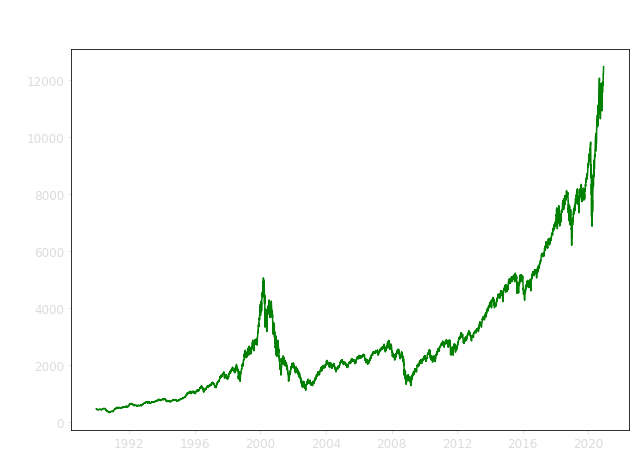

In [17]:
data = Ticker("^BSP").history(start="2002-01-01",
                               #end="2020-12-04",
                               interval="1d")
data.reset_index("symbol", inplace=True, drop=True)

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[-1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data)

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["close"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the closing prices\n", fontsize=20, color="#ffffff");
ax.set_ylabel("Closing prices", fontsize="15", color="#ffffff");
ax.set_xlabel("Date", fontsize="15", color="#ffffff");

Javascript("google.colab.output.setIframeHeight('500px');")

#### **1.2) Pre-processing data**

In [18]:
data = StocksData(
    data_df=data,
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,  
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
)

print("  [TRAINING RANGE] %s to %s" % (
    data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
print("[VALIDATION RANGE] %s to %s" % (
    data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
print("      [TEST RANGE] %s to %s" % (
    data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))

  [TRAINING RANGE] 1990-01-02 to 2016-02-02
[VALIDATION RANGE] 2016-04-15 to 2019-03-11
      [TEST RANGE] 2019-05-22 to 2020-09-24


In [19]:
print(">>> NORMALIZED TRAINING DATA:")
display(data.norm_train["features"].tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(data.norm_val["features"].tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(data.norm_test["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

>>> NORMALIZED TRAINING DATA:


,open,low,high,close,volume
date,,,,,
2016-01-27,0.862332,0.846129,0.864787,0.846593,0.459375
2016-01-28,0.859257,0.845446,0.857642,0.854463,0.505190
2016-01-29,0.854823,0.858524,0.873984,0.876384,0.570663
2016-02-01,0.870237,0.869607,0.878669,0.877696,0.430020
2016-02-02,0.870461,0.856847,0.869079,0.856562,0.474780




>>> NORMALIZED VALIDATION DATA:


,open,low,high,close,volume
date,,,,,
2019-03-05,1.481640,1.480077,1.482606,1.481765,0.465340
2019-03-06,1.480229,1.471125,1.478601,1.467371,0.487560
2019-03-07,1.461530,1.450078,1.460261,1.450111,0.531475
2019-03-08,1.431020,1.436904,1.444446,1.447389,0.488141
2019-03-11,1.453112,1.459345,1.474362,1.478026,0.484043




>>> NORMALIZED TEST DATA:


,open,low,high,close,volume
date,,,,,
2020-09-18,2.173984,2.114783,2.171634,2.139157,1.264357
2020-09-21,2.099810,2.090091,2.131883,2.136198,0.851776
2020-09-22,2.153538,2.134783,2.172036,2.173971,0.764585
2020-09-23,2.169364,2.109241,2.168443,2.106401,0.893777
2020-09-24,2.087740,2.090241,2.135311,2.114428,0.895137


<IPython.core.display.Javascript object>

In [20]:
sample_x, sample_y = next(iter(data.train_ds))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 50, 5)
Sample label shape: (32, 3)


## **2) Defining a model**

In [21]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),  
        ])

        self._pre_lowest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
             tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"), 
        ])

        self._pre_highest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [8]:
# testing output shape
x, y = next(iter(data.train_ds))
MultiLSTM()(x).shape

TensorShape([32, 3])

## **3) Training the model**

204/204 [==============================] - 15s 74ms/step - loss: 0.0010 - mean_absolute_error: 0.0232 - val_loss: 0.0248 - val_mean_absolute_error: 0.1352





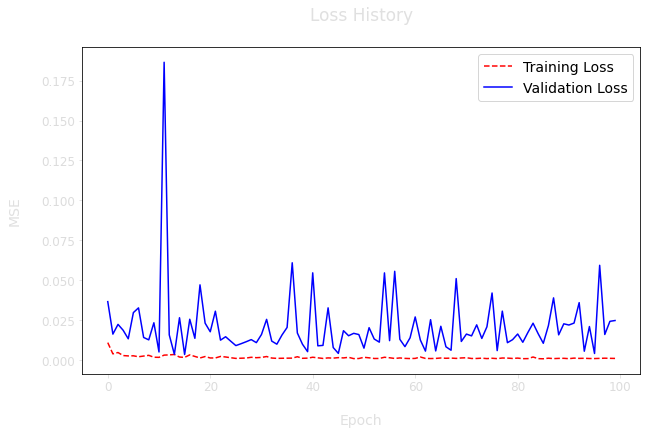

In [22]:
# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 100
history = model.fit(data.train_ds.shuffle(buffer_size=len(data.train_ds)), 
                    validation_data=data.val_ds,
                    epochs=epochs,
                    callbacks=[ClearCallback()])

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **3) Evaluating the model**

#### **3.1) Training data**

     Training Data

#########################

[> GENERAL <]
   . MAE:   147
   . MAPE:  6.7928%
   . MSE:   222657

#########################

[> OPEN <]
   . MAE:   147
   . MAPE:  6.7927%
   . MSE:   222646

#########################

[> LOW <]
   . MAE:   147
   . MAPE:  6.7925%
   . MSE:   222634

#########################

[> HIGH <]
   . MAE:   147
   . MAPE:  6.7924%
   . MSE:   222623

#########################


<IPython.core.display.Javascript object>

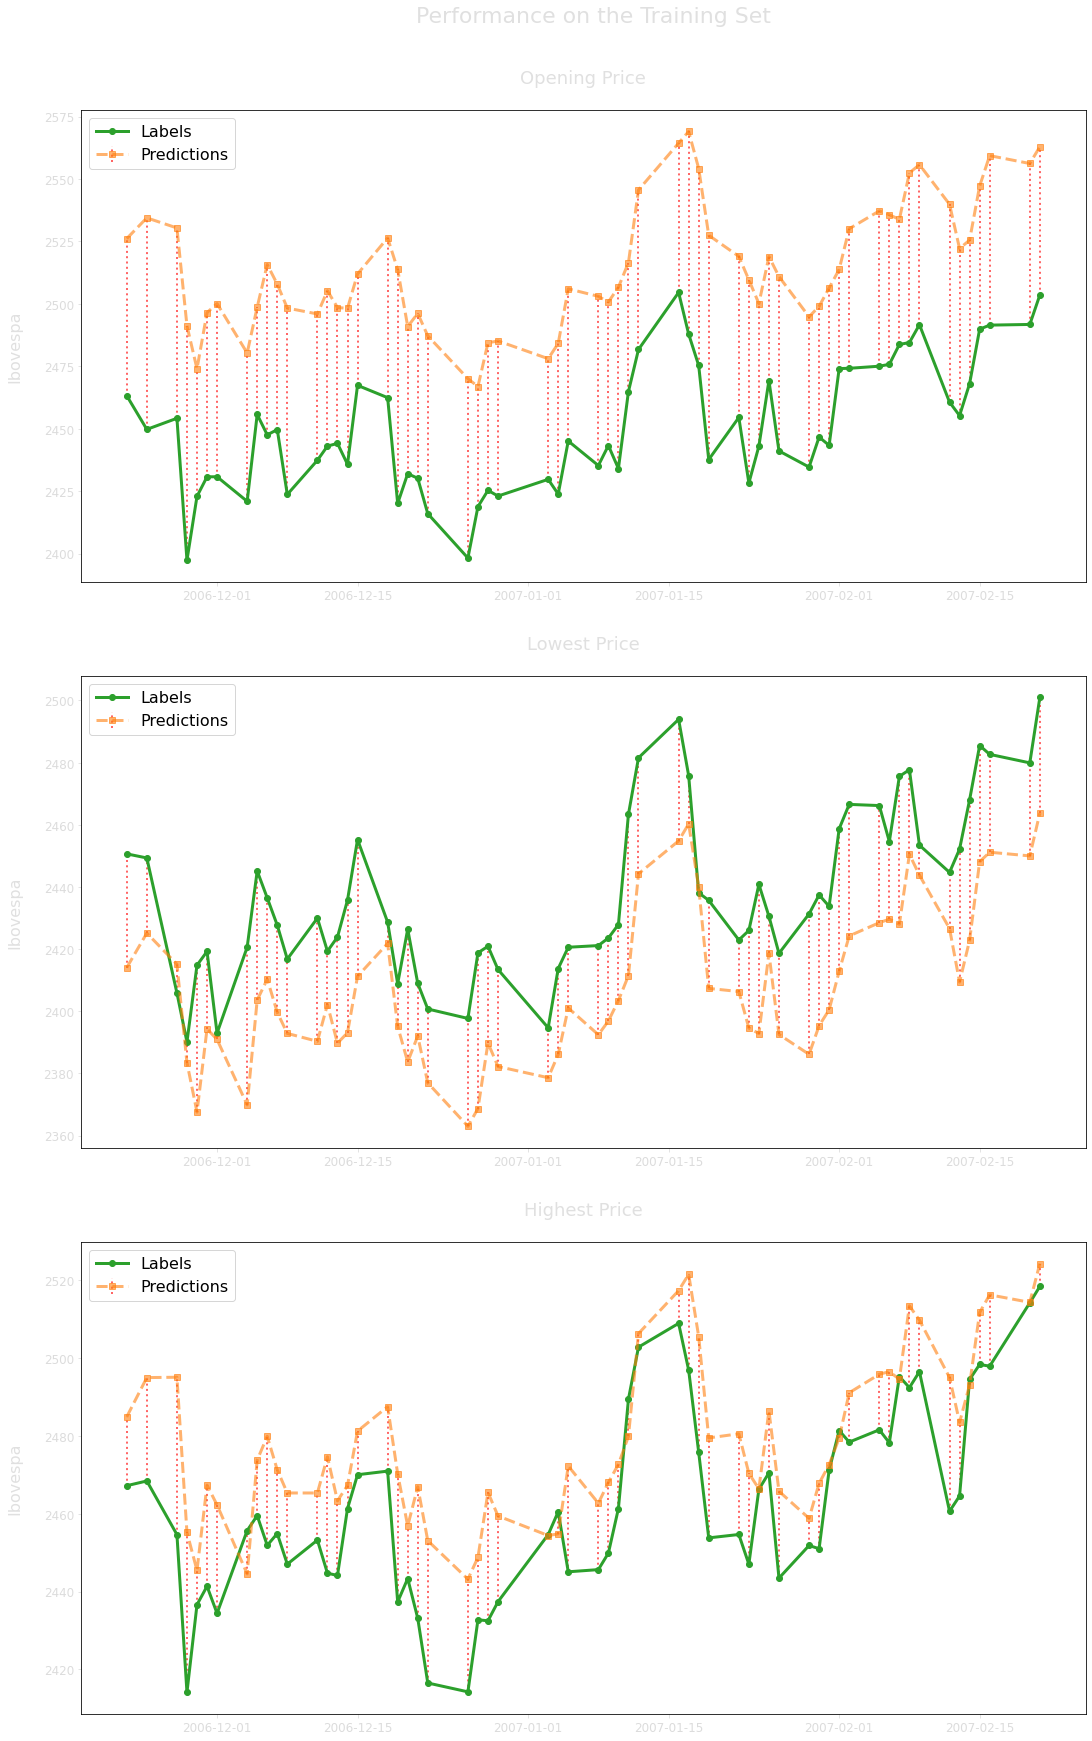

In [23]:
train_predictions, train_results = eval(model, data, "train")

print("     Training Data\n")
eval_print(train_results)

eval_plot(train_predictions, 
          data.raw_train["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Training Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   165
   . MAPE:  6.8877%
   . MSE:   235476

#########################

[> OPEN <]
   . MAE:   165
   . MAPE:  6.8877%
   . MSE:   235479

#########################

[> LOW <]
   . MAE:   165
   . MAPE:  6.8879%
   . MSE:   235492

#########################

[> HIGH <]
   . MAE:   165
   . MAPE:  6.8881%
   . MSE:   235531

#########################


<IPython.core.display.Javascript object>

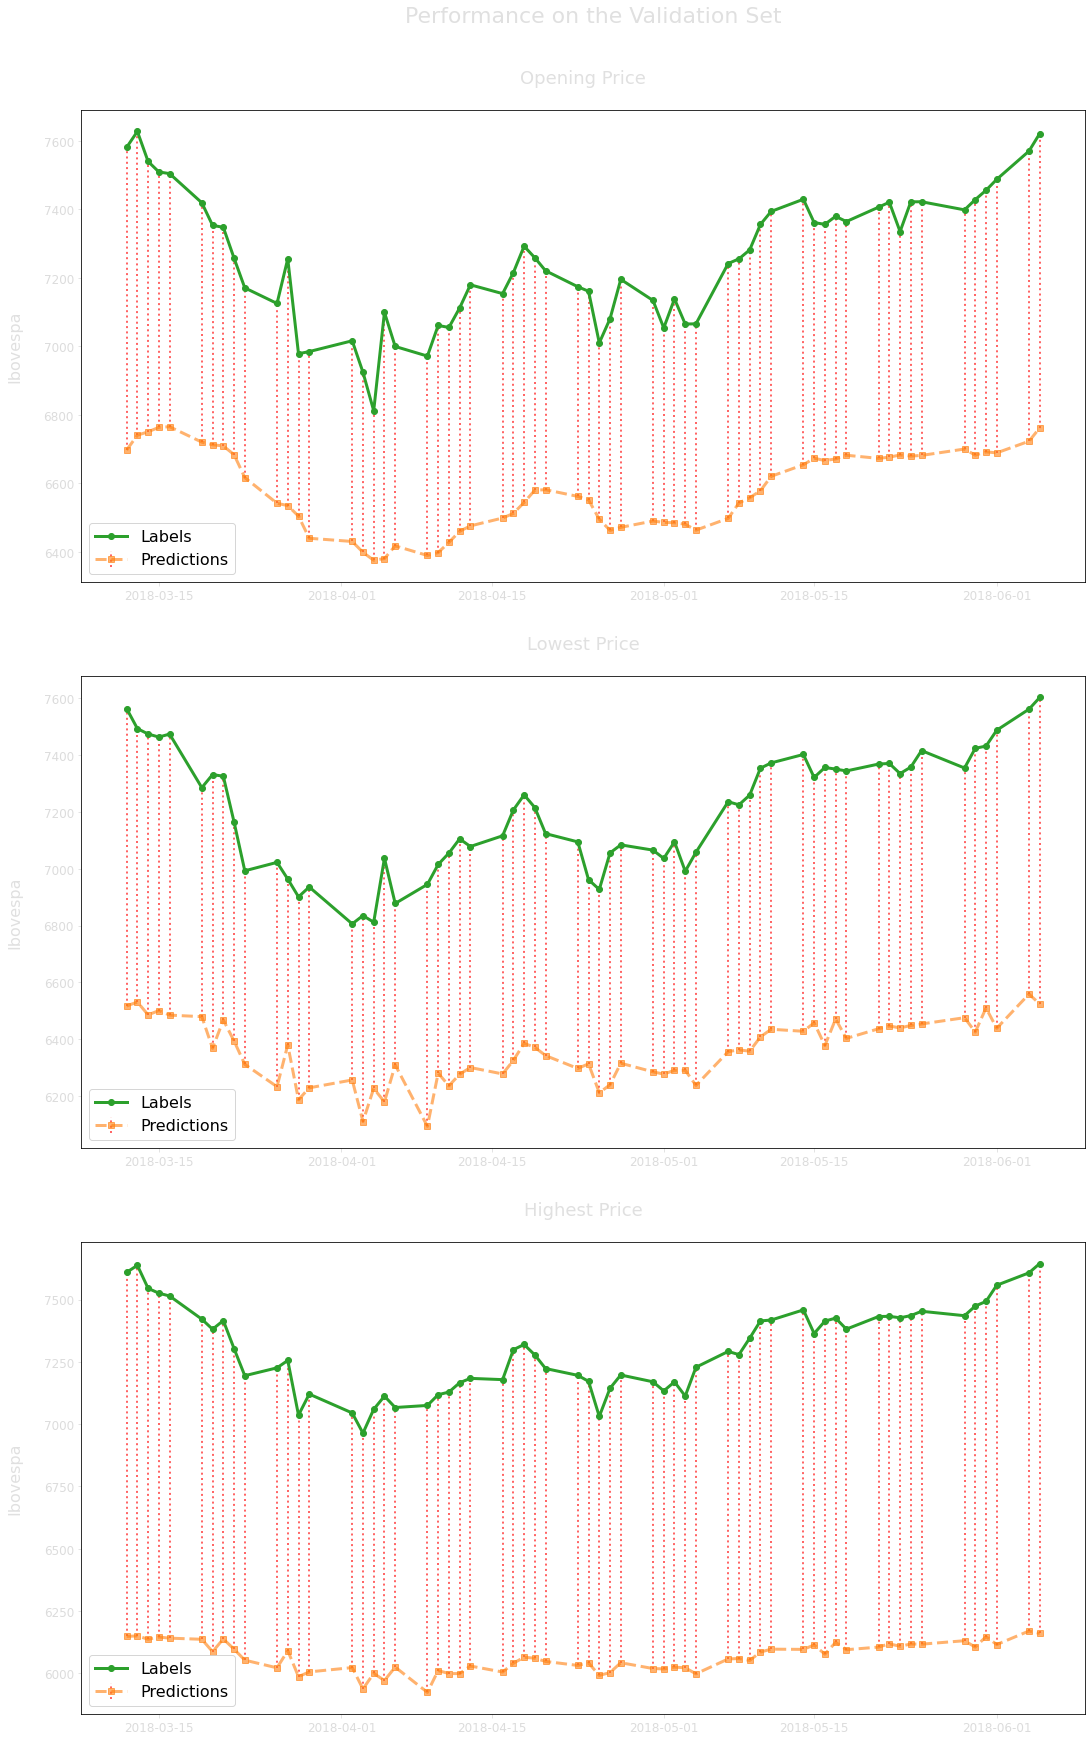

In [24]:
val_predictions, val_results = eval(model, data, "val")

print("     Validation Data\n")
eval_print(val_results)

eval_plot(val_predictions, 
          data.raw_val["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Validation Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.3) Test data**

     Test Data

#########################

[> GENERAL <]
   . MAE:   192
   . MAPE:  7.1048%
   . MSE:   306034

#########################

[> OPEN <]
   . MAE:   192
   . MAPE:  7.1053%
   . MSE:   306165

#########################

[> LOW <]
   . MAE:   192
   . MAPE:  7.1059%
   . MSE:   306351

#########################

[> HIGH <]
   . MAE:   193
   . MAPE:  7.1070%
   . MSE:   306750

#########################


<IPython.core.display.Javascript object>

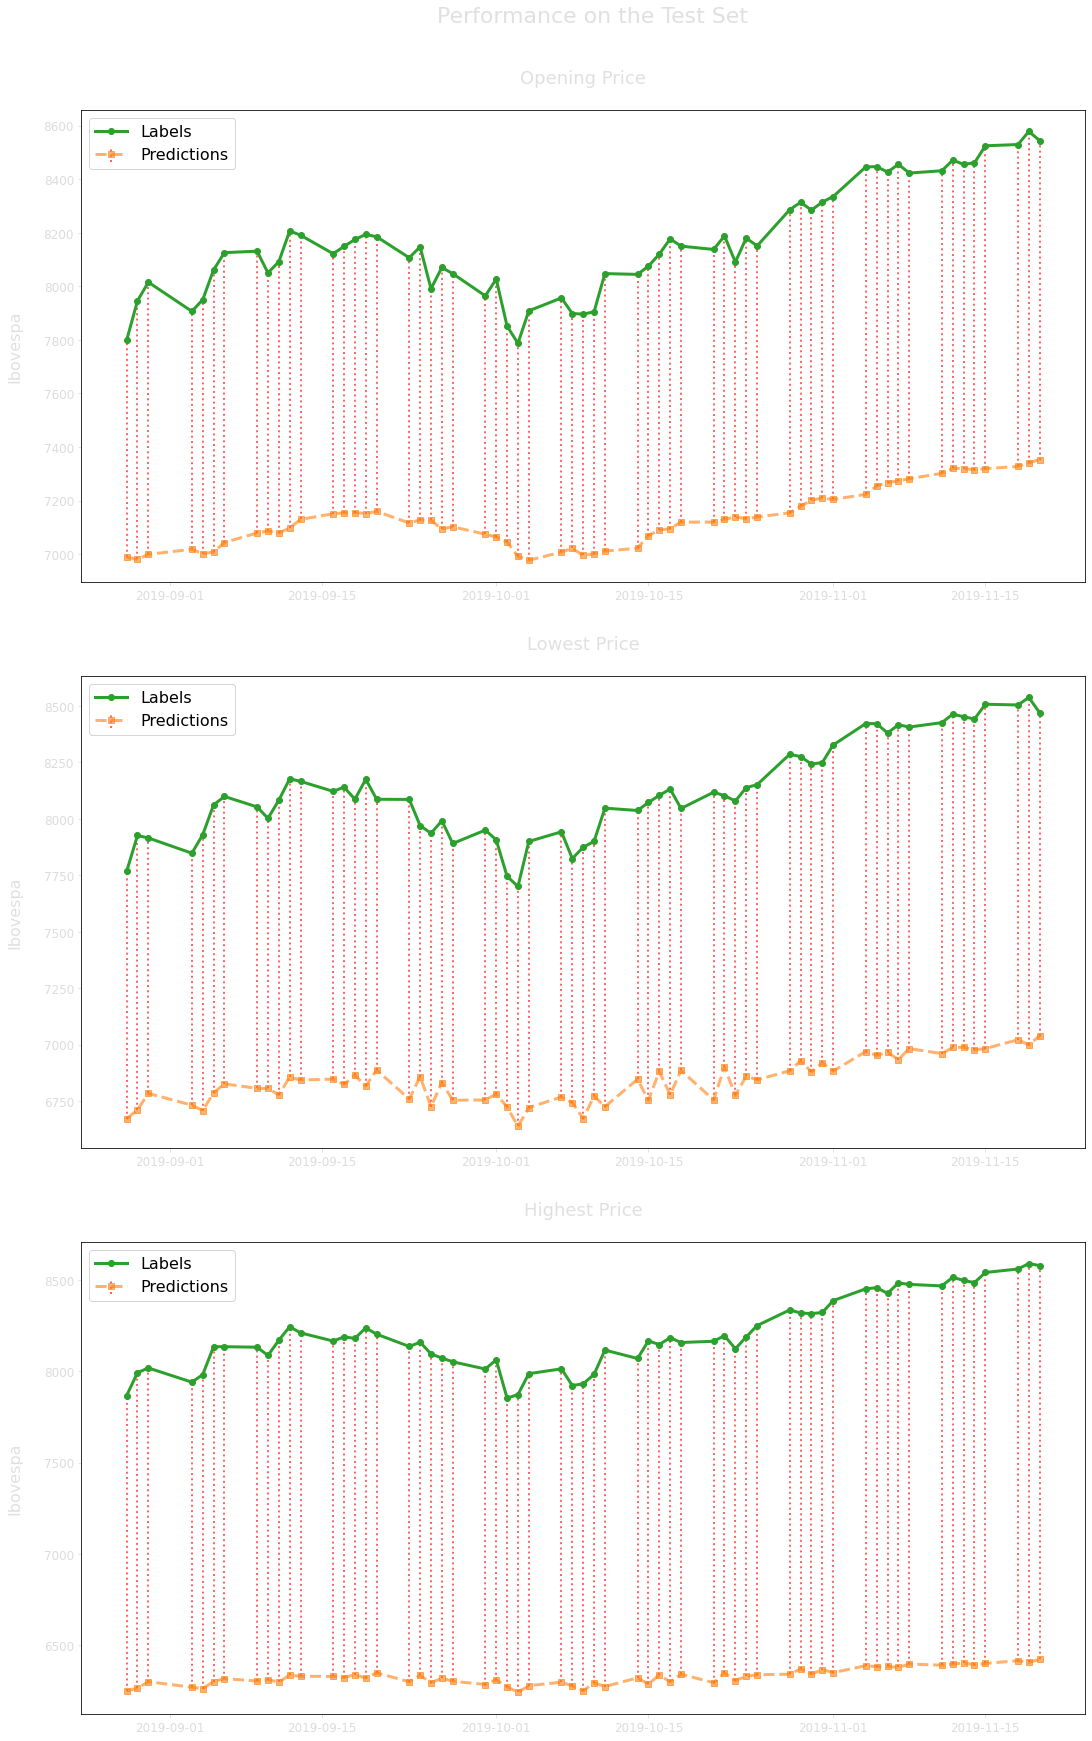

In [25]:
test_predictions, test_results = eval(model, data, "test")

print("     Test Data\n")
eval_print(test_results)

eval_plot(test_predictions, 
          data.raw_test["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Test Set")

Javascript("google.colab.output.setIframeHeight('600px');")